In [1]:
import numpy as np
import pandas as pd

import random

from sklearn.base import BaseEstimator
from sklearn.dummy import DummyRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, column_or_1d
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict

from tscv import GapKFold

from time import time, localtime, strftime

%matplotlib inline

The aim is to build a training pipeline and apply it on a small number of (building, meter)

We won't use a scikitlearn pipeline as it does not allow to clean data by deleting rows.<br>
(as explained here : https://stackoverflow.com/questions/25539311/custom-transformer-for-sklearn-pipeline-that-alters-both-x-and-y)

In [2]:
test_df = pd.read_csv('../data/raw/csvs/test.csv', parse_dates=['timestamp'])

In [3]:
test_df.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01
1,1,1,0,2017-01-01
2,2,2,0,2017-01-01
3,3,3,0,2017-01-01
4,4,4,0,2017-01-01


In [4]:
bdata = pd.read_csv(
    '../data/raw/csvs/building_metadata.csv', 
    index_col='building_id', 
    usecols=['building_id', 'site_id']
)
bdata.head()

,site_id
building_id,
0,0
1,0
2,0
3,0
4,0


In [5]:
test_df = test_df.join(bdata, on='building_id', how='left')

In [6]:
test_df.head()

,row_id,building_id,meter,timestamp,site_id
0,0,0,0,2017-01-01,0
1,1,1,0,2017-01-01,0
2,2,2,0,2017-01-01,0
3,3,3,0,2017-01-01,0
4,4,4,0,2017-01-01,0


<b>Pipeline functions</b>

In [7]:
def load_and_prepare_site_data(site_id, data_folder_path):
    
    # Loads weather data
    raw_df_weather = pd.read_csv(data_folder_path + 'weather_train.csv', 
                     parse_dates=['timestamp'], index_col=['site_id', 'timestamp'])

    b_df_weather = raw_df_weather.loc[(site_id,)]

    # keep only air_temperature and dew_temperature
    b_df_weather.drop(
        ['precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'cloud_coverage'],
        axis=1,
        inplace=True
    )

    # Clean timestamps index.
    clean_index = pd.date_range(start=b_df_weather.index.min(), end=b_df_weather.index.max(), freq='H')
    b_df_weather = b_df_weather.reindex(index=clean_index, copy=True)


    # Interpolate missing values.
    b_df_weather.interpolate(method='linear', limit=3, inplace=True)

    # Build time features
    b_df_weather['day_hour'] = b_df_weather.index.to_series().dt.hour
    b_df_weather['day_of_week'] = b_df_weather.index.to_series().dt.dayofweek

    # Builds averaged weather features.

    timeframes = [24]
    features_to_avg = ['air_temperature', 'dew_temperature']
    do_center = False

    for c in features_to_avg:
        ts = b_df_weather[c]
        for timeframe in timeframes:
            shifted_ts = ts.rolling(timeframe, center=do_center).mean()
            new_col_name = '' + c + '_ma_' + str(timeframe) + 'H'
            b_df_weather[new_col_name] = shifted_ts
            
            
    # Drops rows with NaNs.
    b_df_weather.dropna(axis=0, how='any', inplace=True)
            
    print('shape={}'.format(b_df_weather.shape))
        
    return b_df_weather

In [33]:
# Loads meter_reading data
def load_meter_data(data_folder_path):
    return pd.read_csv(data_folder_path + 'train.csv', parse_dates=['timestamp'])

In [34]:
# Selects only meter data from a specific building and meter id. 
def filter_meter_data(df, building_id, meter_id):
    
    to_keep = (df['building_id']==building_id) & (df['meter']==meter_id)
    b_df_meters = df[to_keep].copy()

    b_df_meters.drop('building_id', axis=1, inplace=True)
    b_df_meters.drop('meter', axis=1, inplace=True)

    b_df_meters.set_index('timestamp', inplace=True)
    b_df_meters.sort_index(inplace=True)
    
    return b_df_meters

In [9]:
"""
Drops rows that are not in both dtaframe indexes.
Converts Y from pd.df to pd.Series
"""

def prepare_meter_train_set(site_weather_df, building_meter_df):
    
    common_index = site_weather_df.index.intersection(other=building_meter_df.index)
    
    # Reset indexes
    
    X = site_weather_df.loc[common_index].copy()
    Y = building_meter_df.loc[common_index].copy()

    return (X, Y['meter_reading'])

<b>Model functions</b>

In [10]:
class MeanByMultiCatEstimator(BaseEstimator):
    """ A template estimator to be used as a reference implementation.
    For more information regarding how to build your own estimator, read more
    in the :ref:`User Guide <user_guide>`.
    Parameters
    ----------
    demo_param : str, default='demo_param'
        A parameter used for demonstation of how to pass and store paramters.
    """
    def __init__(self, cat_column_indexes=[0], verbose=False):
        self.verbose = verbose
        self.cat_column_indexes = cat_column_indexes

    def fit(self, X, y):
        """A reference implementation of a fitting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
        
        X, y = check_X_y(X, y, accept_sparse=True)
        """Input validation for standard estimators.
        Checks X and y for consistent length, enforces X to be 2D and y 1D. By
        default, X is checked to be non-empty and containing only finite values.
        Standard input checks are also applied to y, such as checking that y
        does not have np.nan or np.inf targets. For multi-label y, set
        multi_output=True to allow 2D and sparse y. If the dtype of X is
        object, attempt converting to float, raising on failure.
        """
        
        
        cat_columns = []
        
        for col_idx in self.cat_column_indexes:
            if(col_idx >= X.shape[1]):
                raise ValueError("category column indexes should be < X.shape[1]")
            cat_columns.append(X[:, col_idx])
            
        cat_tuples = set(zip(*cat_columns))
        
        categories = {}
        self.means = {}
        
        self.mean = y.mean()
        
        for x_bin in cat_tuples:
            categories[x_bin] = []
            
        if self.verbose:    
            print('categories : {}'.format(categories.keys()))
            
        for k in range(X.shape[0]):
            sample_bin = tuple(X[k, self.cat_column_indexes])
            categories[sample_bin].append(y[k])
        
        for k, v in categories.items():
            self.means[k] = np.array(v).mean()
        
        self.is_fitted_ = True
        # `fit` should always return `self`
        
        if self.verbose:
            for k, v in self.means.items():
                print('({}, {})'.format(k, v))
        
        return self

    
    
    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns an array of ones.
        """
        
        
        X = check_array(X, accept_sparse=True)
        """Input validation on an array, list, sparse matrix or similar.
        By default, the input is checked to be a non-empty 2D array containing
        only finite values. If the dtype of the array is object, attempt
        converting to float, raising on failure."""
        
        check_is_fitted(self, 'is_fitted_')
        
        predictions = []
        
        
        cat_columns=[]
        for col in self.cat_column_indexes:
            cat_columns.append(X[:, col])
            
        cat_tuples = list(zip(*cat_columns))
        
        
        
        for sample_cat in cat_tuples:
            cat_mean = self.means.get(sample_cat)
            if(cat_mean == None):
                predictions.append(self.mean)
            else:
                predictions.append(cat_mean)
            
        
        
        return np.array(predictions)

<b>Main</b>

In [11]:
bdata.head()

,site_id
building_id,
0,0
1,0
2,0
3,0
4,0


In [12]:
site_ids = bdata['site_id'].unique().tolist()

In [13]:
train_df = pd.read_csv('../data/raw/csvs/train.csv', parse_dates=['timestamp'])

In [14]:
train_df_grouped = train_df.groupby(['building_id', 'meter']).count()
train_df_grouped.drop('timestamp', axis=1, inplace=True)
train_df_grouped.rename({'meter_reading' : 'n_meter_readings'}, axis=1, inplace=True)
train_df_grouped.sort_values(by='n_meter_readings', axis=0, ascending=False, inplace=True)

In [15]:
train_df_grouped = train_df_grouped.join(bdata, on='building_id', how='left')

In [16]:
train_df_grouped.head()

,,n_meter_readings,site_id
building_id,meter,,
0,0,8784,0
685,0,8784,5
672,0,8784,5
673,0,8784,5
674,0,8784,5


In [17]:
# main
"""

for site in site_id:

    load_and_prepare_site_data()

    for building on this site:
        
        for meter in building_meter:
        
            load_meter_data()
            prepare_train_set()
            
            cross-validate()
            fit()
            
            save()



"""




'\n\nfor site in site_id:\n\n    load_and_prepare_site_data()\n\n    for building on this site:\n        \n        for meter in building_meter:\n        \n            load_meter_data()\n            prepare_train_set()\n            \n            cross-validate()\n            fit()\n            \n            save()\n\n\n\n'

In [18]:
train_df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2380 entries, (0, 0) to (403, 0)
Data columns (total 2 columns):
n_meter_readings    2380 non-null int64
site_id             2380 non-null int64
dtypes: int64(2)
memory usage: 55.6 KB


In [19]:
train_df_grouped.iloc[:2000].tail()

,,n_meter_readings,site_id
building_id,meter,,
1003,3,8306,10
815,0,8255,8
810,0,8255,8
853,0,8208,8
1273,1,8194,14


In [58]:
# sub-sample train_df

np.random.seed(102)

# sample among first 2000 meters (with the most observations by meters)
subsample_indexes = np.random.choice(2000, 20, replace=False)

subsample_building_meters = train_df_grouped.iloc[subsample_indexes]

In [59]:
subsample_building_meters

,,n_meter_readings,site_id
building_id,meter,,
723,0,8784,5
969,1,8778,9
1242,3,8784,14
682,0,8784,5
346,0,8782,3
189,0,8781,2
154,0,8784,1
1237,3,8784,14
250,1,8782,2


In [60]:
subsample_building_meters.index.get_level_values('building_id').unique().tolist()

[723,
 969,
 1242,
 682,
 346,
 189,
 154,
 1237,
 250,
 41,
 268,
 1254,
 263,
 454,
 1308,
 942,
 402,
 901,
 202,
 920]

In [61]:
subsample_site_ids = subsample_building_meters['site_id'].unique()
subsample_site_ids

array([ 5,  9, 14,  3,  2,  1,  0])

In [51]:
data_folder = '../data/raw/csvs/'

tot_start_time = time()

meter_data_df = load_meter_data(data_folder)

results = []

for site_id in subsample_site_ids:
    
    print('.site {}'.format(site_id))
    
    site_weather_data = load_and_prepare_site_data(site_id, data_folder)
    
    # GapKFold
    # gap ~ two weeks, train = 1 month (12 folds)
    gap = 24*7*2
    gap_kf = GapKFold(n_splits=12, gap_before=gap, gap_after=gap)
    
    site_building_meters = subsample_building_meters[subsample_building_meters['site_id']==site_id]
    site_buildings = site_building_meters.index.get_level_values('building_id').unique().tolist()
    #site_buildings.sort_values(by='building_id', axis='index', inplace=True)
    
    print(site_buildings)
    
    for building in site_buildings:
        
        building_meters = site_building_meters.loc[building].index.tolist()
        
        for building_meter in building_meters:
            
            print('\t.(building, meter)=({}, {})'.format(building, building_meter))
            
            load_meter_start_time = time()
            meter_df = filter_meter_data(meter_data_df, building, building_meter)
            load_meter_end_time = time()
            print('\tload_meter time : %s seconds' % (load_meter_end_time-load_meter_start_time))
            
            print('\t\tmeter_df.shape={}'.format(meter_df.shape))
            
            x_train, y_train = prepare_meter_train_set(site_weather_data, meter_df)
            
            # Dummy estimator cross-validation score
            
            dummy_score = cross_val_score(
                estimator=DummyRegressor(strategy="mean"),
                X=x_train,
                y=y_train,
                scoring='neg_mean_squared_log_error',
                cv=gap_kf
            ).mean()
            
            print('\t\tdummy_score={}'.format(dummy_score))
            
            # Time-only model cross-validation score
            
            day_hour_col_idx = x_train.columns.to_list().index('day_hour')
            day_of_week_col_idx = x_train.columns.to_list().index('day_of_week')
            time_col_indexes = [day_hour_col_idx, day_of_week_col_idx]
            
            time_avg_score = cross_val_score(
                estimator=MeanByMultiCatEstimator(time_col_indexes),
                X=x_train,
                y=y_train,
                scoring='neg_mean_squared_log_error',
                cv=gap_kf
            ).mean()
            
            print('\t\ttime_avg_score={}'.format(time_avg_score))
            
            # Time + weather random forest model
            
            rfr_grid_params = {
                'n_estimators' : [30, 40, 50, 60, 75, 100, 125, 150],
                'max_features' : ['sqrt'],
                'max_depth' : [6, 8, 10, 12, 14, 16]
            }

            
            # ------
            gcv_start_time = time()
            
            rfr_CV = GridSearchCV(
                estimator=RandomForestRegressor(), 
                param_grid=rfr_grid_params,
                scoring='neg_mean_squared_log_error',
                n_jobs=6,
                iid=False,
                cv=gap_kf
            )
            
            rfr_CV.fit(x_train, y_train)

            rfr_score = rfr_CV.best_score_
            
            gcv_end_time = time()
            print('\t\tgcv time : %s seconds' % (gcv_end_time-gcv_start_time))
            # ------
            
            print('\t\tbest_params : {}'.format(rfr_CV.best_params_))
            print('\t\tbest_score : {}'.format(rfr_score))
            
            rfr_improvement = - (rfr_score-time_avg_score) / time_avg_score * 100 ;
            
            print('\t\trfr improvement = {}%'.format(rfr_improvement))
            
            best_n_estimators = rfr_CV.best_params_['n_estimators']
            best_max_depth = rfr_CV.best_params_['max_depth']
            
            result_row = [
                building, 
                building_meter, 
                best_n_estimators, 
                best_max_depth, 
                rfr_improvement
            ]
            
            results.append(result_row)
            
    print('--')
    
tot_end_time = time()
print('total time : %s seconds' % (tot_end_time-tot_start_time))

col_names = ['building', 'meter_id', 'n_estimators', 'max_depth', 'rfr_improvement']
results_df = pd.DataFrame(results, columns=col_names)

	-> reading time : 13.113684892654419 seconds
.site 5
shape=(8707, 6)
[723, 682]
	.(building, meter)=(723, 0)
	-> filtering time : 0.12380194664001465 seconds
	load_meter time : 0.1259016990661621 seconds
		meter_df.shape=(8784, 1)
		dummy_score=-3.262917301171566
		time_avg_score=-3.1095751678833508
		gcv time : 45.839186668395996 seconds
		best_params : {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 40}
		best_score : -3.22750713257749
		rfr improvement = -3.7925426570219902%
	.(building, meter)=(682, 0)
	-> filtering time : 0.056368350982666016 seconds
	load_meter time : 0.05839896202087402 seconds
		meter_df.shape=(8784, 1)
		dummy_score=-0.22292376616670864
		time_avg_score=-0.11042779775559657
		gcv time : 45.15566825866699 seconds
		best_params : {'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 100}
		best_score : -0.07059876015105217
		rfr improvement = 36.067945222176476%
--
.site 9
shape=(8760, 6)
[969, 942, 901, 920, 991]
	.(building, meter)=(969, 1)
	-> f

		dummy_score=-0.19990102438884041
		time_avg_score=-0.1114296746552914
		gcv time : 53.875463008880615 seconds
		best_params : {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 125}
		best_score : -0.0943729457868334
		rfr improvement = 15.307169226889625%
	.(building, meter)=(202, 3)
	-> filtering time : 0.05679655075073242 seconds
	load_meter time : 0.05854463577270508 seconds
		meter_df.shape=(8334, 1)
		dummy_score=-0.48782044215078996
		time_avg_score=-0.48823056660684155
		gcv time : 50.898406982421875 seconds
		best_params : {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 40}
		best_score : -0.3650919814545313
		rfr improvement = 25.221400210173712%
	.(building, meter)=(185, 0)
	-> filtering time : 0.05640697479248047 seconds
	load_meter time : 0.05815482139587402 seconds
		meter_df.shape=(8774, 1)
		dummy_score=-0.21095216290531657
		time_avg_score=-0.052551906850353
		gcv time : 54.74639940261841 seconds
		best_params : {'max_depth': 16, 'max_features': 'sqrt'

In [52]:
results_df

,building,meter_id,n_estimators,max_depth,rfr_improvement
0,723,0,40,8,-3.792543
1,682,0,100,12,36.067945
2,969,1,60,12,45.686084
3,942,2,50,6,2.066287
4,901,1,75,8,32.708050
5,920,0,75,6,-7.049375
6,991,0,125,6,-2.665801
7,1242,3,40,14,61.824666
8,1237,3,30,16,22.906841
9,1254,1,30,12,69.886764


In [53]:
import seaborn as sns

In [54]:
results_df_rfr = results_df[results_df['rfr_improvement'] > 0]

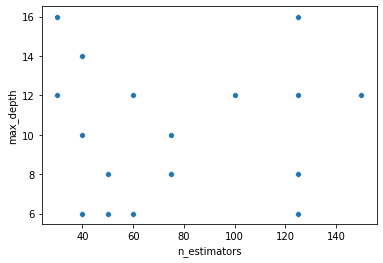

In [55]:
sns.scatterplot(x="n_estimators", y="max_depth", data=results_df_rfr)

In [56]:
results_df_rfr['n_estimators'].mean()

73.75

In [57]:
results_df_rfr['max_depth'].mean()

10.4

Let's comparer fr improvement with grid search and without (model rfr max_depth = 10 et n_estimators = 70)

In [62]:
data_folder = '../data/raw/csvs/'

tot_start_time = time()

meter_data_df = load_meter_data(data_folder)

results = []

for site_id in subsample_site_ids:
    
    print('.site {}'.format(site_id))
    
    site_weather_data = load_and_prepare_site_data(site_id, data_folder)
    
    # GapKFold
    # gap ~ two weeks, train = 1 month (12 folds)
    gap = 24*7*2
    gap_kf = GapKFold(n_splits=12, gap_before=gap, gap_after=gap)
    
    site_building_meters = subsample_building_meters[subsample_building_meters['site_id']==site_id]
    site_buildings = site_building_meters.index.get_level_values('building_id').unique().tolist()
    #site_buildings.sort_values(by='building_id', axis='index', inplace=True)
    
    print(site_buildings)
    
    for building in site_buildings:
        
        building_meters = site_building_meters.loc[building].index.tolist()
        
        for building_meter in building_meters:
            
            print('\t.(building, meter)=({}, {})'.format(building, building_meter))
            
            load_meter_start_time = time()
            meter_df = filter_meter_data(meter_data_df, building, building_meter)
            load_meter_end_time = time()
            print('\tload_meter time : %s seconds' % (load_meter_end_time-load_meter_start_time))
            
            print('\t\tmeter_df.shape={}'.format(meter_df.shape))
            
            x_train, y_train = prepare_meter_train_set(site_weather_data, meter_df)
            
            # Dummy estimator cross-validation score
            
            dummy_score = cross_val_score(
                estimator=DummyRegressor(strategy="mean"),
                X=x_train,
                y=y_train,
                scoring='neg_mean_squared_log_error',
                cv=gap_kf
            ).mean()
            
            print('\t\tdummy_score={}'.format(dummy_score))
            
            # Time-only model cross-validation score
            
            day_hour_col_idx = x_train.columns.to_list().index('day_hour')
            day_of_week_col_idx = x_train.columns.to_list().index('day_of_week')
            time_col_indexes = [day_hour_col_idx, day_of_week_col_idx]
            
            time_avg_score = cross_val_score(
                estimator=MeanByMultiCatEstimator(time_col_indexes),
                X=x_train,
                y=y_train,
                scoring='neg_mean_squared_log_error',
                cv=gap_kf
            ).mean()
            
            print('\t\ttime_avg_score={}'.format(time_avg_score))
            
            # Time + weather random forest model
            
            rfr_grid_params = {
                'n_estimators' : [30, 40, 50, 60, 75, 100, 125, 150],
                'max_features' : ['sqrt'],
                'max_depth' : [6, 8, 10, 12, 14, 16]
            }

            
            # ------
            gcv_start_time = time()
            
            rfr_CV = GridSearchCV(
                estimator=RandomForestRegressor(), 
                param_grid=rfr_grid_params,
                scoring='neg_mean_squared_log_error',
                n_jobs=6,
                iid=False,
                cv=gap_kf
            )
            
            rfr_CV.fit(x_train, y_train)

            rfr_score = rfr_CV.best_score_
            
            gcv_end_time = time()
            print('\t\tgcv time : %s seconds' % (gcv_end_time-gcv_start_time))
            # ------
            
            print('\t\tbest_params : {}'.format(rfr_CV.best_params_))
            print('\t\tbest_score : {}'.format(rfr_score))
            
            rfr_improvement = - (rfr_score-time_avg_score) / time_avg_score * 100 ;
            print('\t\trfr improvement = {}%'.format(rfr_improvement))
            
            no_gcv_start_time = time()
            
            rfr_no_gcv_score = cross_val_score(
                estimator=RandomForestRegressor(n_estimators=70, max_depth=10),
                X=x_train,
                y=y_train,
                scoring='neg_mean_squared_log_error',
                cv=gap_kf
            ).mean()
            
            no_gcv_end_time = time()
            print('\t\tno_gcv time : %s seconds' % (no_gcv_end_time-no_gcv_start_time))
            
            rfr_improvement_no_gcv = - (rfr_no_gcv_score-time_avg_score) / time_avg_score * 100 ;
            
            best_n_estimators = rfr_CV.best_params_['n_estimators']
            best_max_depth = rfr_CV.best_params_['max_depth']
            
            result_row = [
                building, 
                building_meter, 
                best_n_estimators, 
                best_max_depth, 
                rfr_improvement,
                rfr_improvement_no_gcv
            ]
            
            results.append(result_row)
            
    print('--')
    
tot_end_time = time()
print('total time : %s seconds' % (tot_end_time-tot_start_time))

col_names = ['building', 'meter_id', 'n_estimators', 'max_depth', 'rfr_improvement', 'rfr_improvement_no_gcv']
results_df = pd.DataFrame(results, columns=col_names)

	-> reading time : 13.062613487243652 seconds
.site 5
shape=(8707, 6)
[723, 682]
	.(building, meter)=(723, 0)
	-> filtering time : 0.08210420608520508 seconds
	load_meter time : 0.08401298522949219 seconds
		meter_df.shape=(8784, 1)
		dummy_score=-3.262917301171566
		time_avg_score=-3.1095751678833508
		gcv time : 45.907371282577515 seconds
		best_params : {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 50}
		best_score : -3.2295650583213464
		rfr improvement = -3.8587229431624035%
		no_gcv time : 9.897758483886719 seconds
	.(building, meter)=(682, 0)
	-> filtering time : 0.0557100772857666 seconds
	load_meter time : 0.0577852725982666 seconds
		meter_df.shape=(8784, 1)
		dummy_score=-0.22292376616670864
		time_avg_score=-0.11042779775559657
		gcv time : 45.32931327819824 seconds
		best_params : {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
		best_score : -0.06964196480850766
		rfr improvement = 36.93438950703139%
		no_gcv time : 9.906202793121338 seconds
--
.

		dummy_score=-0.48782044215078996
		time_avg_score=-0.48823056660684155
		gcv time : 51.91878604888916 seconds
		best_params : {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 125}
		best_score : -0.3732690481044245
		rfr improvement = 23.546563112872924%
		no_gcv time : 11.6291983127594 seconds
--
.site 1
shape=(8688, 6)
[154]
	.(building, meter)=(154, 0)
	-> filtering time : 0.05825686454772949 seconds
	load_meter time : 0.06070280075073242 seconds
		meter_df.shape=(8784, 1)
		dummy_score=-0.031402413930993696
		time_avg_score=-0.008688265516967138
		gcv time : 57.74197006225586 seconds
		best_params : {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 60}
		best_score : -0.008668987768007867
		rfr improvement = 0.22188259465164878%
		no_gcv time : 13.001357555389404 seconds
--
.site 0
shape=(8761, 6)
[41]
	.(building, meter)=(41, 0)
	-> filtering time : 0.06028270721435547 seconds
	load_meter time : 0.06368327140808105 seconds
		meter_df.shape=(8784, 1)
		dummy_score

In [63]:
results_df

,building,meter_id,n_estimators,max_depth,rfr_improvement,rfr_improvement_no_gcv
0,723,0,50,8,-3.858723,-8.520370
1,682,0,100,10,36.934390,32.490715
2,969,1,100,14,45.654554,46.593362
3,942,2,125,6,1.936568,-16.424503
4,901,1,50,10,32.781569,29.748062
5,920,0,30,6,-7.226157,-15.760639
6,1242,3,75,14,61.633545,63.544438
7,1237,3,40,14,23.240056,28.861793
8,1254,1,30,12,69.590925,70.160677
9,1308,0,60,6,-3.373289,-7.398279


<u>Conclusion</u><br>
We observe significant improvement with grid search.<br>
But it takes more time (1 min vs 15s)